In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Conv1D, GlobalMaxPooling1D, SpatialDropout1D
from keras.metrics import Precision, Recall
from keras.optimizers import Adam

# **PHISHING DETECTION WITH LSTM-CNN**

* * *

## Dataset

The dataset we're going to use is the one that combines URL, SMS, Emails and Webs datasets. With this we'll evaluate how RNNs models perform in NLP tasks, specifically: text classification in phishing or benign. It's worth mentioning that this combined dataset is already preprocessed, so we just have to import it.

In [2]:
train = pd.read_json('../DATASETS/FINAL/train.json')
test= pd.read_json('../DATASETS/FINAL/test.json')
train

,text,label
0,https://www.a10.com/multiplayer-games,0
1,matthewpryor.com/,0
2,<!doctypehtml><title>\n Hopper - definition ...,0
3,mylife.com/c-1509246489,0
4,http://printerstudent.com/ssl/cmd-login=7b7adf...,1
...,...,...
61660,"( no subject ) stinson , henwood can help us w...",0
61661,http://yourdreamtv.com.ng/ok/protected/index.html,1
61662,nipple-hypochlorite.com,1
61663,https://vlkkkeb.asia/index.php?id=,1


## Tokenization & Padding

Tokenization, in the realm of Natural Language Processing (NLP) and machine learning, refers to the process of converting a sequence of text into smaller parts, known as tokens. These tokens can be as small as characters or as long as words. The primary reason this process matters is that it helps machines understand human language by breaking it down into bite-sized pieces, which are easier to analyze.

In the other side, padding is a critical technique used to manage the spatial dimensions of input data. Padding is the process of adding layers of zeros or other values outside the actual data in an input matrix. The primary purpose of padding is to preserve the spatial size of the input so that the output after applying filters (kernels) remains the same size, or to adjust it according to the desired output dimensions.

In [3]:
# The maximum number of words to be used (most frequent)
MAX_NUM_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 100

In [4]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)

tokenizer.fit_on_texts(train['text'])
# Transform text to sequences of numbers
X_train = tokenizer.texts_to_sequences(train['text'])
# Pad sequences to preserve their the spatial size
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)

# same with test 
X_test = tokenizer.texts_to_sequences(test['text'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)

X_train

array([[    0,     0,     0, ...,     8, 14054,   797],
       [    0,     0,     0, ...,     0,     0,     8],
       [10212,    57,    23, ...,  1527,  2182,    17],
       ...,
       [    0,     0,     0, ...,     0,     0,     8],
       [    0,     0,     0, ...,   165,   151,    11],
       [ 1218,    49,   342, ...,    17,     3,     3]], dtype=int32)

## LSTM-CNN

Long Short-Term Memory (LSTM) networks are a type of recurrent neural network capable of learning order dependence in sequence prediction problems.

Recurrent neural networks are different from traditional feed-forward neural networks. This difference in the addition of complexity comes with the promise of new behaviors that the traditional methods cannot achieve. Recurrent networks have an internal state that can represent context information. They keep information about past inputs for an amount of time that is not fixed a priori, but rather depends on its weights and on the input data. It contain cycles that feed the network activations from a previous time step as inputs to the network to influence predictions at the current time step. These activations are stored in the internal states of the network which can in principle hold long-term temporal contextual information. This mechanism allows RNNs to exploit a dynamically changing contextual window over the input sequence history.

Standard RNNs fail to learn in the presence of time lags greater than 5 – 10 discrete time steps between relevant input events and target signals. The vanishing error problem casts doubt on whether standard RNNs can indeed exhibit significant practical advantages over time window-based feedforward networks. **“Long Short-Term Memory” (LSTM)** model is not affected by this problem. LSTM can learn to bridge minimal time lags in excess of 1000 discrete time steps by enforcing constant error flow through “constant error carrousels” (CECs) within special units, called cells.

A **Convolutional neural network (CNN)** is a discriminative architecture that works effectively at processing grid-based two-dimensional data, including images and videos. In terms of time delay, the CNN outperforms the neural network (NN). The weights are shared in a temporal dimension in the CNN, which reduces calculation time. The standard NN’s generic matrix multiplication is thus replaced in the CNN. As a result, the CNN technique minimizes the weights, lowering the network’s complexity.

**LSTM–CNN** architecture involves both CNN and LSTM methods in order to make use of the benefits of both methods and accomplish excellent performance. Since CNN and LSTM show high performance in overcoming classification, detection, and recognition tasks, to using these three methods for the phishing detection task is promising. The LSTM—CNN model consists of CNN layers that extract features from input data and LSTM layers that predict sequences. Furthermore, a study found that combining a 1D convolution layer and an LSTM layer improves the accuracy of malicious URL identification when compared to models that exclusively use LSTM layers. As a result, when constructing the system, we chose 1D CNN and LSTM architecture to train the phishing dataset.

Alshingiti, Z., Alaqel, R., Al-Muhtadi, J., Haq, Q. E. U., Saleem, K., & Faheem, M. H. (2023). A Deep Learning-Based Phishing Detection System Using CNN, LSTM, and LSTM-CNN. Electronics, 12(1), 232. https://doi.org/10.3390/electronics12010232


In [5]:
EMBEDDING_DIM = 50

# init layer
model = Sequential()
# embedded layer that uses EMBEDDING_DIM length vectors to represent each word.
model.add(Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# SpatialDropout1D performs variational dropout in NLP models.
model.add(SpatialDropout1D(0.2))
# LSTM Layer
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
# combining a 1D convolution layer and an LSTM layer improves the accuracy 
# of malicious samples when compared to models that exclusively use LSTM layers
model.add(Conv1D(50, kernel_size=3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32))
# The output layer will have 1 output value
# Activation function is sigmoid for binary classification.
model.add(Dense(1, activation="sigmoid"))
# Because it is a binary classification problem, binary_crossentropy is used as the loss function.
model.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss="binary_crossentropy", 
    metrics=['accuracy', Precision(), Recall()]
)

# output model skeleton
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           2500000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100, 100)          60400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           30200     
                                                                 
 conv1d (Conv1D)             (None, 98, 50)            7550      
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                         

Start training ...

In [6]:
EPOCHS = 4
BATCH_SIZE = 16

history = model.fit(
    X_train, 
    train['label'], 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    validation_data=(X_test, test['label'])
)

Epoch 1/4
3855/3855 [==============================] - 244s 63ms/step - loss: 0.4233 - accuracy: 0.7757 - precision: 0.7717 - recall: 0.6644 - val_loss: 0.2654 - val_accuracy: 0.8897 - val_precision: 0.8474 - val_recall: 0.9006
Epoch 2/4
3855/3855 [==============================] - 232s 60ms/step - loss: 0.2266 - accuracy: 0.9044 - precision: 0.8743 - recall: 0.9030 - val_loss: 0.2357 - val_accuracy: 0.9027 - val_precision: 0.8901 - val_recall: 0.8775
Epoch 3/4
3855/3855 [==============================] - 231s 60ms/step - loss: 0.1816 - accuracy: 0.9230 - precision: 0.8965 - recall: 0.9241 - val_loss: 0.2151 - val_accuracy: 0.9092 - val_precision: 0.8850 - val_recall: 0.9017
Epoch 4/4
3855/3855 [==============================] - 235s 61ms/step - loss: 0.1561 - accuracy: 0.9326 - precision: 0.9082 - recall: 0.9347 - val_loss: 0.2139 - val_accuracy: 0.9128 - val_precision: 0.8908 - val_recall: 0.9040


Model performance on training and validation sets:

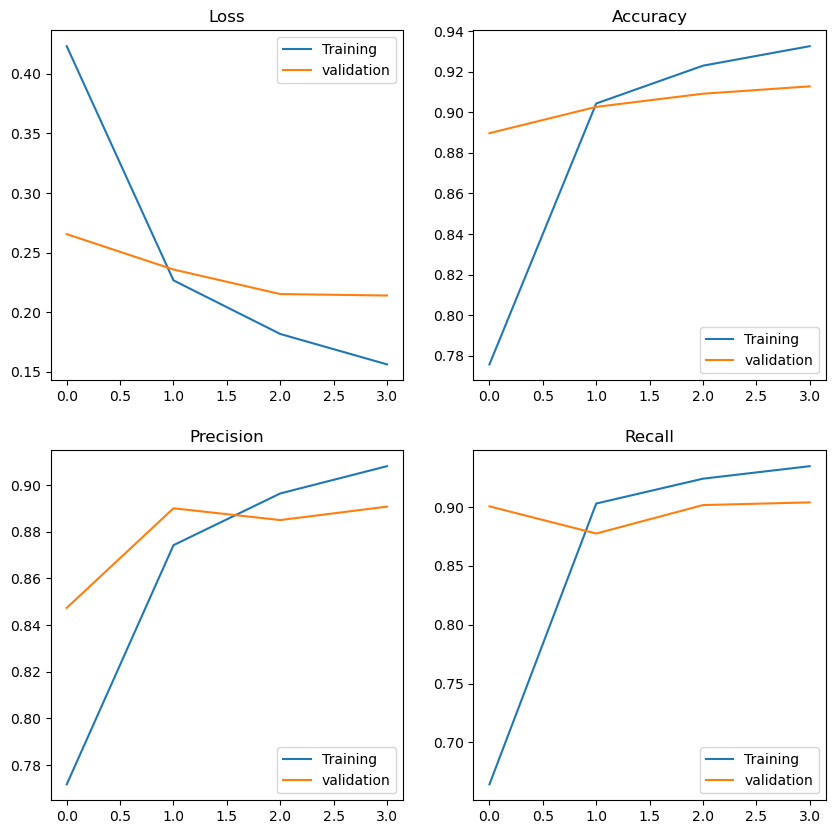

In [7]:
results = history.history

# Create a figure and a 2x2 grid of axes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Plot the data on each axis
axs[0, 0].plot(results['loss'])
axs[0, 0].plot(results['val_loss'])
axs[0, 0].set_title('Loss')
axs[0, 0].legend(("Training", "validation"), loc="upper right")
axs[0, 1].plot(results['accuracy'])
axs[0, 1].plot(results['val_accuracy'])
axs[0, 1].set_title('Accuracy')
axs[0, 1].legend(("Training", "validation"), loc="lower right")
axs[1, 0].plot(results['precision'])
axs[1, 0].plot(results['val_precision'])
axs[1, 0].set_title('Precision')
axs[1, 0].legend(("Training", "validation"), loc="lower right")
axs[1, 1].plot(results['recall'])
axs[1, 1].plot(results['val_recall'])
axs[1, 1].set_title('Recall')
axs[1, 1].legend(("Training", "validation"), loc="lower right")

plt.show()

Model performance on test sest:

In [8]:
evaluation = model.evaluate(X_test, test['label'])
print("\n#### RESULTS:")
print(f"Loss: {evaluation[0]:.5f}")
print(f"Accuracy: {evaluation[1]:.5f}")
print(f"Precision: {evaluation[2]:.5f}")
print(f"Recall: {evaluation[3]:.5f}")

482/482 [==============================] - 10s 21ms/step - loss: 0.2139 - accuracy: 0.9128 - precision: 0.8908 - recall: 0.9040

#### RESULTS:
Loss: 0.21390
Accuracy: 0.91282
Precision: 0.89081
Recall: 0.90397


Testing on a real phishing example:

In [9]:
phishing_example = ("\nDear colleague, An important update about your email has exceeded your storage limit. " 
                    "\nYou will not be able to send or receive all of your messages. We will close all older "
                    "\nversions of our Mailbox as of Friday, June 12, 2023. To activate and complete the "
                    "\nrequired information click here. Account must be reactivated today to regenerate new "
                    "\nspace. Management Team")

x = pad_sequences(tokenizer.texts_to_sequences(phishing_example), maxlen=MAX_SEQUENCE_LENGTH)
prediction = np.mean(model.predict(x))
print(phishing_example)

if prediction < 0.5:
    print(f"\n--> The text is Benign (confidence: {(1-prediction)*100:.3f}%)")
else:
    print(f"\n--> The text is Phishing (confidence: {prediction*100:.3f}%)")

12/12 [==============================] - 1s 18ms/step

Dear colleague, An important update about your email has exceeded your storage limit. 
You will not be able to send or receive all of your messages. We will close all older 
versions of our Mailbox as of Friday, June 12, 2023. To activate and complete the 
required information click here. Account must be reactivated today to regenerate new 
space. Management Team

--> The text is Phishing (confidence: 79.230%)
